# Specialisatieopdracht Data Science

## Jaron Koelewijn - Maarten Botter - Jeroen Boshuis
Welcome to our specialisation asignment, in this assignment we will use a dataset of the football club NEC. 
We will show different statistics and show different graphs using these datasets to give as much info about the players performance.

# Quick Installation Guide
### Requirements:
    1. The files of the matches must be placed under a map named: gps
    2. the map named: gps - must be saved in de C:// directory.
    3. The files must come from matches in the current season.
    4. The files must be of the same content used in the previous files.
    5. If step 2 cant be done, than you must change the directory in de code, and the namesplitter.
    6. Anaconda must be installed to access all the imports.

# Imports
Here are all the import we need for this notebook. If anaconda was installed all of these were brought with it. If not than use the PIP module to install the import to your pc

In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import ipywidgets as widgets
import os
import glob
import json
import datetime
import pytz
from bokeh.charts import Line, Bar, BoxPlot, Histogram, Scatter, output_notebook, show
from bokeh.layouts import row, widgetbox, gridplot
from bokeh.io import push_notebook, show, output_notebook
from ipywidgets import interact
%matplotlib notebook
output_notebook()

Loading BokehJS ...

The steps to create a DataSet format we would like:

    1. First we get the dates and exact times of the game's starting signal, normally this would be an API, but an soccer-API wasnt affordable.

    2. Second, we get the location of the map of the specified games add all the file-names into different dicts that we can later use.
    
    3. At last, we change the time to a nice readable time fond, delete the not working columns and the ones we arent going to use. We also add a ID to each "file" so we can later at least somewhat know who is who.

### Step: 1

In [2]:
date_starttimes = {}
t = (("2015-07-04", '18:30'),("2015-07-11", '18:30'),
     ("2015-07-14", '19:00'),("2015-07-18", '14:30'),
     ("2015-07-21", '18:30'),("2015-07-25", '16:00'),
     ("2015-08-01", '19:00'),("2015-08-12", '20:45'),
     ("2015-08-16", '16:45'),("2015-08-22", '20:45'),
     ("2015-08-28", '20:00'),("2015-09-02", '18:30'),
     ("2015-09-12", '18:30'),("2015-09-18", '20:00'),
     ("2015-09-22", '20:00'),("2015-09-26", '20:45'),
     ("2015-10-03", '18:30'),("2015-10-08", '14:00'),
     ("2015-10-18", '12:30'),("2015-10-25", '14:30'),
     ("2015-10-29", '18:30'),("2015-11-01", '16:45'),
     ("2015-11-07", '19:45'),("2015-11-22", '14:30'),
     ("2015-11-29", '12:30'),("2015-12-06", '14:30'),
     ("2015-12-12", '19:45'),("2015-12-15", '18:30'),
     ("2015-12-20", '14:30'),("2016-01-08", '15:30'),
     ("2016-01-17", '16:45'),("2016-01-22", '20:00'),
     ("2016-01-27", '18:30'),("2016-01-30", '20:45'),
     ("2016-02-07", '14:30'),("2016-02-14", '16:45'),
     ("2016-02-20", '19:45'),("2016-02-26", '20:00'),
     ("2016-03-06", '12:30'),("2016-03-13", '16:45'),
     ("2016-03-20", '14:30'),("2016-03-24", '16:00'),
     ("2016-04-03", '12:30'),("2016-04-10", '14:30'),
     ("2016-04-17", '14:30'),("2016-04-20", '18:30'),
     ("2016-05-01", '14:30'),("2016-05-08", '14:30'))
date_starttimes = dict(t)

### Step: 2

In [3]:
my_dir = 'C:\\gps'
game_dates = {}
gameList = []
game_dir = {}
filesList = []
filesdict = {}
os.chdir(my_dir)
for x in os.walk(my_dir):
    
    if x[0] != my_dir:
        wedstrijd = x[0].split("gps",1)[1][10:]
        gamedate = x[0].split("gps",1)[1][1:9]
        gameList.append(wedstrijd)
        testdate = datetime.datetime.strptime(gamedate, '%Y%m%d').replace(tzinfo=pytz.utc)
        testdate = pytz.timezone('Europe/Amsterdam').normalize(testdate)
        game_dates[wedstrijd] = testdate
        game_dir[wedstrijd] = x[0]
        
        
for game in game_dir.keys():
    os.chdir(game_dir[game])    
    
    for files in glob.glob("*.txt"):
        fileName, fileExtension = os.path.splitext(files)
        filesList.append(files)
        
    filesdict[game] = filesList
    filesList = []

In [4]:
import builtins

### Step: 3

In [5]:
game_data = {}

for game in filesdict.keys():
        game_data[game] = {}
        sprintsPerPlayer = {}
        playerid = 1
        DST = False
        if game_dates[game].strftime("%H:%M:%S") == '02:00:00':
            DST = True
        totalFrame = pd.DataFrame()
        os.chdir(game_dir[game])
        for file in filesdict[game]:
            sprintFrame = pd.DataFrame()
            frame = pd.read_csv(file, skiprows= 3, quoting=0, encoding='utf8', index_col = False, sep=',', names=['Tijd', 'DT', 'lat', 'lon', 'snelheid', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z', 'NOTOFINTEREST', 'Heart Rate'])
            frame = frame[frame['Tijd'] != '-']
            frame['ID'] = playerid
            game_data[game][playerid] = {}
            frame['Time'] = pd.to_datetime(frame['Tijd'], format='%H%M%S.%f')
            frame['Dist_thisTick'] = frame['snelheid']/10
            if DST == True:
                frame['Time'] = frame['Time'] + pd.DateOffset(hours=2)
                frame['Time'] = frame['Time'].dt.strftime('%H:%M:%S.%f')
            else:
                frame['Time'] = frame['Time'] + pd.DateOffset(hours=1)
                frame['Time'] = frame['Time'].dt.strftime('%H:%M:%S.%f')
            gamedate = game_dates[game].strftime("%Y-%m-%d")
            gametime = date_starttimes[gamedate]
            mask = (frame['Time'] >= gametime)
            del frame['Tijd']
            del frame['Heart Rate']
            del frame['NOTOFINTEREST']
            del frame['mag_y']
            del frame['mag_x']
            del frame['mag_z']
            del frame['DT']
            frame = frame.loc[mask]
            if totalFrame.empty == True:
                totalFrame = frame
            else:
                totalFrame = totalFrame.append(frame, ignore_index = True)
            game_data[game][playerid]['data'] = frame
            game_data[game][playerid]['Total_Distance'] = frame['Dist_thisTick'].sum()
            
            #Checking for sprints in each player's stats
            #If speed is over 5 m/s, True, otherwise False
            frame['spr'] = frame['snelheid'] > 5
            
            #Find all first True's after a False
            firstRow = frame.index[frame['spr'] & ~ frame['spr'].shift(1).fillna(False)]
            #Find all last True's before a False
            lastRow = frame.index[frame['spr'] & ~ frame['spr'].shift(-1).fillna(False)]
            #Store first and last values in a list if there is a margin of 10 (1 second)
            sprintIntervals = [(i, j) for i, j in zip(firstRow, lastRow) if j > i + 10]
            if len(sprintIntervals):
                i, j = sprintIntervals[0]
                sprints = len(sprintIntervals)
                sprintsPerPlayer[playerid] = sprints
            else:
                sprintsPerPlayer[playerid] = 0
            playerid += 1
        li = []
        g1 = []
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in sprintsPerPlayer.items()]))
        for i in range(1,len(game_data[game])):
            lis = list(set(df[i]))
            li.append(lis)
            g1.append(i)
        d = pd.DataFrame(li, index=g1)
        d['playerID'] = d.index
        d.columns = ['Sprints','playerID']
        d
        game_data[game]['sprints'] = d
        game_data[game]['total'] = totalFrame
    

# Some Quick Statistics

Here we are going to show some quick and easy statistics, showing more basic info and graphs

We are going to show:
1. Total distance ran per player per game
2. Average speed per player per game (M/S)
3. Average speed of the whole team per game (M/S)
4. Amount of sprints per player per game

# 1. Total distance ran per player per game
Here, we will use the above calculated total distance ran per player, and plot it out

With this info you can quite clearly see who is the most active player on the field, and possilby calculate were NEC plays the most according to the most active players positions.

### First, the needed dataframe is created

In [6]:
#Create Dataframe with 10000 empty rows
list = range(1,10000)
Total_distance = pd.DataFrame(columns = ['Distance', 'PlayerID', 'Game'])
Total_distance['PlayerID'] = Total_distance['PlayerID'].astype(int)

# Initiate index counter for .loc insertion
i = 0
for game in game_data:
    for playerid in range(1,len((game_data[game]))-2):                  #The range max is set to game_data[game]-2 
        player_dist = game_data[game][playerid]['Total_Distance']       #because this dictionary also includes ['sprints'] and  
        Total_distance.loc[i] = [player_dist, playerid, game]           #['total'],which are not players.
        i += 1
Total_distance = Total_distance.dropna(how='all')

### After the dataframe is created and filled, it gets passed to a Bokeh chart, with grouping per game.
#### The user can select one or multiple games in a select box to render the graph with grouping per game. 
##### (CTRL+click or click and drag to select multiple)

In [7]:
def update(GameList):
    Selected_distance = Total_distance.loc[Total_distance['Game'].isin(GameList)]
    line = Bar(Selected_distance, label='PlayerID', values='Distance', group='Game', title='Test', 
               width=800, height=800, xlabel='Speler',
               tooltips=[('Average speed','@height{int}'), ('Player','@PlayerID{int}'), ('Game','@Game')])
    show(line, notebook_handle=True)
    push_notebook()
interact(update, GameList = widgets.SelectMultiple(options=gameList, value=[gameList[0]]))

# 2. Average speed per player per game
Over here we are getting all the games we have and calculating every players average speed per M/S through the whole game. As above you can see here who the fastest was. It can help account to see which postion which player plays. For example, if a player that is a front-line attacker, didnt run fast, you have either: 1. a very bad attacker or 2. a very bad mid-line who cant pass the ball to the front-line leaving them idle for the most of the game.

In [8]:
li = []
g1 = []
dic = {}
for game in game_data:
    gem_snel = []
    data = game_data[game]['total']
    last = data['ID'].iloc[-1]
    for number in range(1, last+1):
        playerData = pd.DataFrame(game_data[game][number]['data'])
        gemiddelde_snelheid = playerData['snelheid'].mean()
        gem_snel.append(gemiddelde_snelheid)
    dic[game] = gem_snel
    
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in dic.items()]))
df = df.fillna(0)
print (df)
def update(Game):
    line = Bar(df, values=Game, label='index', color='index', title=Game, 
               width=500, height=500, legend=False, xlabel='Spelers',
               tooltips=[('Average speed','@height m/s'), ('Player','@index')])
    show(line, notebook_handle=True)
    push_notebook()
interact(update, Game=gameList)

<function __main__.update>

# 3. Average speed of the whole team per game
Over here we are showing the average speed of the whole team in M/S, as you can see in de Bar Chart, In the third game against "Roda JC", NEC ran the faster. And the first game against "FC Utrecht" they ran the slowest. Here you can see the overall speed of the whole team, this helps to figure out against which they struggle the most. And if it depends whether you are playing home or at someone else's stadium.

In [21]:
li = []
g1 = []
for game in game_data:
    lis = df[game].mean()
    li.append(lis)
    g1.append(game)
    
s = pd.DataFrame(li, index=g1)
s['gemiddelde'] = s[0]
del s[0]

histo = Bar(s, values='gemiddelde', label='index', color='index', 
            xlabel='Wedstrijd', ylabel='average speed in M/S',
           tooltips=[('Average speed','@height m/s'), ('Game','@index')])

show(histo)

# 4. Amount of sprints per player per game
### Sprint are above the 5 M/s limit

In [22]:
def update(Game):
    data = game_data[Game]['sprints']
    p = Bar(data, values='Sprints', xlabel = 'SpelerID', color = 'index', 
            ylabel = 'Aantal sprints', legend = False,
           tooltips=[('Amounts of sprints','@height'), ('Player','@index')])
    show(p, notebook_handle=True)
    push_notebook()

In [23]:
interact(update, Game=gameList)

# MACHINE LEARNING
Over here we are getting the data of a random selected player's coordinates. And based on those coordinates we can predict were he might be moving to.

first we get the datagrame up

In [24]:
for game in game_data:
    data = game_data[game]['total']

#### Than we delete the data we dont need.

In [25]:
del data['snelheid']
del data['acc_x']
del data['acc_y']
del data['acc_z']
del data['gyro_x']
del data['gyro_y']
del data['gyro_z']
del data['Time']
del data['ID']

#### We select the last data about his movements

In [26]:
pdp = pd.DataFrame(data)
pdp = pdp.tail(1000)

#### We correlize that data to see if it fits.

In [27]:
pdp.corr()

,Dist_thisTick,lat,lon
Dist_thisTick,1.000000,-0.442014,-0.462169
lat,-0.442014,1.000000,0.855544
lon,-0.462169,0.855544,1.000000


#### We get ourselves a x and a y. So we can use those to plot the future

In [31]:
x = pdp['lat']
y = pdp['lon']

#### We calculate the Linear Regressing so we can use that in the plot

In [32]:
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)
linereg = LinearRegression().fit(x, y)
print('m: ', linereg.coef_[0][0])
print('c: ', linereg.intercept_[0])

m:  2.43409513216
c:  -120.303325531


#### And finally we show the plot including the possible "future"

<IPython.core.display.Javascript object>


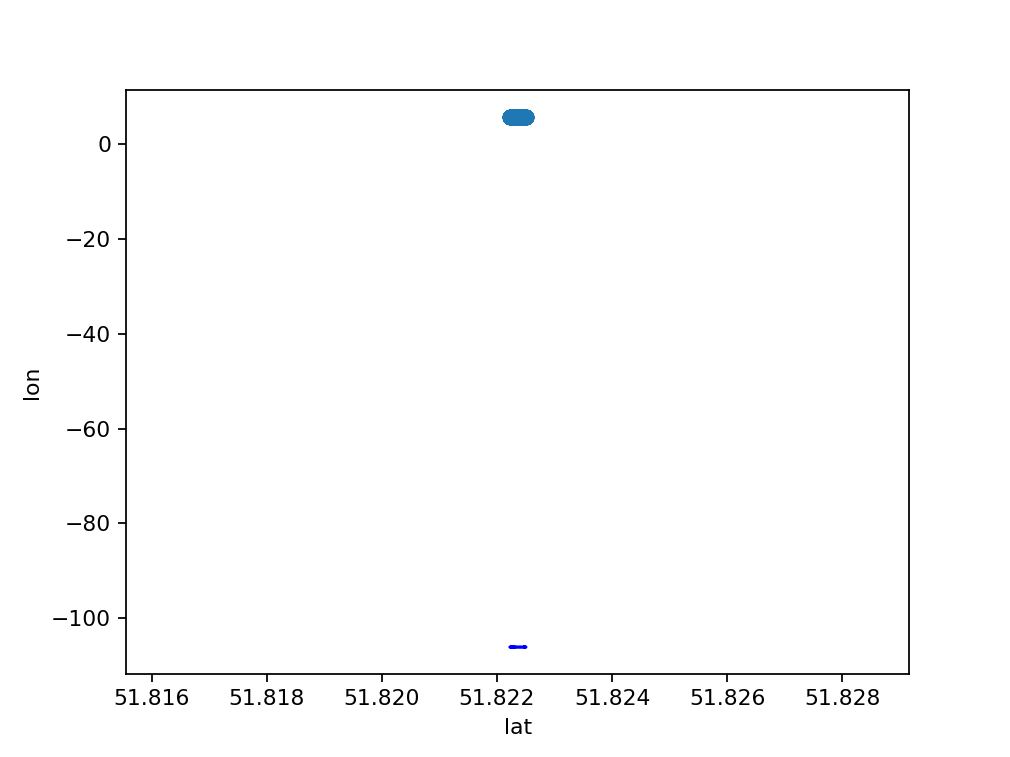

In [33]:
regressie = linereg.predict(y)
plt.scatter(x,y)
plt.plot(x,regressie, color='blue')
plt.xlabel('lat')
plt.ylabel('lon')